# Zadanie: metryki

Dla nauczonego modelu policz metryki wspomniane w poznanym module o klasyfikacji na zbiorze testowym oraz policz macierz omyłek.

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Fitting 5 folds for each of 108 candidates, totalling 540 fits
Najlepsze parametry: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}

Macierz pomyłek:
[[962   4]
 [ 15 134]]


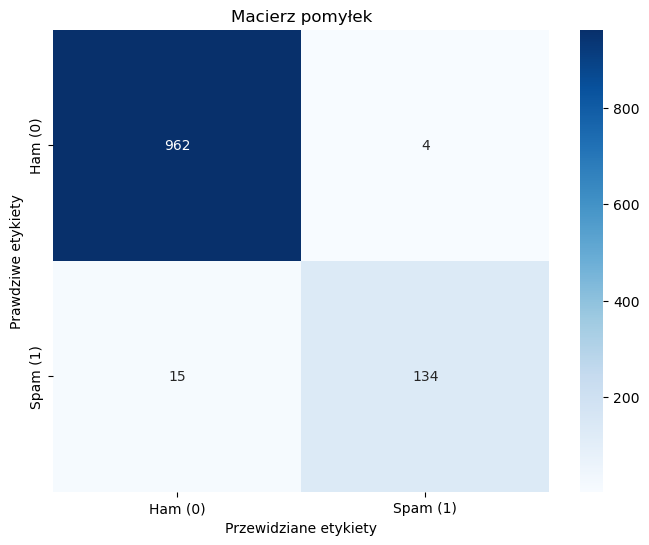


Metryki klasyfikacji:
Accuracy (Dokładność): 0.9830
Precision (Precyzja): 0.9710
Recall (Czułość): 0.8993
F1-score: 0.9338

Szczegółowy raport klasyfikacji:
              precision    recall  f1-score   support

         Ham       0.98      1.00      0.99       966
        Spam       0.97      0.90      0.93       149

    accuracy                           0.98      1115
   macro avg       0.98      0.95      0.96      1115
weighted avg       0.98      0.98      0.98      1115

AUC-ROC: 0.9780
Balanced Accuracy: 0.9476
Average Precision: 0.9562


In [4]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (confusion_matrix, precision_score, recall_score, 
                            f1_score, roc_auc_score, accuracy_score, 
                            classification_report, balanced_accuracy_score,
                            average_precision_score)
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Ładowanie i przygotowanie danych
spam_dataset = pd.read_csv('spam.csv', encoding="ISO-8859-1", usecols=[0, 1], names=['Spam', 'Text'], skiprows=1)
spam_dataset['Spam'] = spam_dataset['Spam'].map({'ham': 0, 'spam': 1}).astype(int)

# 2. Czyszczenie tekstu
nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = ''.join([char for char in text if char.isalpha() or char == ' '])
    text = text.lower()
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return ' '.join(words)

spam_dataset['Cleaned_Text'] = spam_dataset['Text'].apply(clean_text)

# 3. Wektoryzacja i podział danych
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(spam_dataset['Cleaned_Text'])
y = spam_dataset['Spam']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 4. Trenowanie modelu RandomForest z GridSearch
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_tuned = GridSearchCV(
    RandomForestClassifier(class_weight='balanced', random_state=42),
    param_grid,
    cv=5,
    n_jobs=-1,
    verbose=1
)
rf_tuned.fit(X_train, y_train)

# 5. Obliczanie i wyświetlanie metryk
print("Najlepsze parametry:", rf_tuned.best_params_)

# Predykcje
y_pred = rf_tuned.predict(X_test)
y_pred_proba = rf_tuned.predict_proba(X_test)[:, 1]

# Macierz pomyłek
cm = confusion_matrix(y_test, y_pred)
print("\nMacierz pomyłek:")
print(cm)

# Wizualizacja macierzy pomyłek
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Ham (0)', 'Spam (1)'], 
            yticklabels=['Ham (0)', 'Spam (1)'])
plt.title('Macierz pomyłek')
plt.ylabel('Prawdziwe etykiety')
plt.xlabel('Przewidziane etykiety')
plt.show()

# Podstawowe metryki
print("\nMetryki klasyfikacji:")
print(f"Accuracy (Dokładność): {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision (Precyzja): {precision_score(y_test, y_pred):.4f}")
print(f"Recall (Czułość): {recall_score(y_test, y_pred):.4f}")
print(f"F1-score: {f1_score(y_test, y_pred):.4f}")

# Szczegółowy raport
print("\nSzczegółowy raport klasyfikacji:")
print(classification_report(y_test, y_pred, target_names=['Ham', 'Spam']))

# Metryki probabilistyczne
print(f"AUC-ROC: {roc_auc_score(y_test, y_pred_proba):.4f}")
print(f"Balanced Accuracy: {balanced_accuracy_score(y_test, y_pred):.4f}")
print(f"Average Precision: {average_precision_score(y_test, y_pred_proba):.4f}")